# Импорты

In [1]:
# Системные импорты и настройки
import os
import sys
import yaml
import warnings
import ipynbname
import logging.config

warnings.filterwarnings('ignore')

# for local development
RT_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/rt_libs/src"
BA_LIBS_PATH = "/Users/alex/Dev_projects/MyOwnRepo/basic_application/src"
sys.path.append(RT_LIBS_PATH)
sys.path.append(BA_LIBS_PATH)

# read config
with open('config.yaml', "r") as stream:
    config = yaml.safe_load(stream)
    
# set logging config
log_config = config.get("log", None)
logging.config.dictConfig(log_config)

# set notebook alias
ALIAS = ipynbname.name()
print(ALIAS)

PT_1.0


In [2]:
# DS frameworks
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

%matplotlib notebook

In [3]:
# RT packages
from core.observation_builder.precompute import PrecomputeOrderbookDiffFeature
from train_tools import plot_and_go

2023-07-27 23:41:16.427030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Датасет
Работает с датасетом поколения RT5. Пробуем на разных наборах данных.

In [125]:
path_train = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/06.BTC_USDT-60.csv"
#path_train = "/Users/alex/Dev_projects/RT/model_train/datasets/rt5/05.BTC_USDT_PREDICTION-60.csv"

dataset = pd.read_csv(path_train, index_col='ts')
display(dataset.head(3))

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,total_num
ts,,,,,,,,,,,
1676851319,2023-02-20 03:01:59,24303.959,24300.400,"{'24303.96': 0.000275, '24316.89': 0.000586, '...","{'24300.40': 0.319085, '24300.39': 0.411516, '...",0.020080,0.022778,0.042858,5,6,11
1676851379,2023-02-20 03:02:59,24334.871,24313.870,"{'24334.87': 0.889817, '24334.88': 0.000586, '...","{'24313.87': 0.318985, '24313.86': 0.411288, '...",0.042979,0.028549,0.071528,7,10,17
1676851439,2023-02-20 03:03:59,24366.760,24349.092,"{'24366.76': 0.14, '24366.77': 0.884924, '2436...","{'24349.09': 0.183618, '24349.08': 0.14, '2434...",0.036151,0.000975,0.037126,5,5,10


In [233]:
#Конфиг для предварительного обсчета датасета
precompute_config = {
    "orderbook_levels": [0.0005, 0.001, 0.0025, 0.005]
}


po = PrecomputeOrderbookDiffFeature()
for level in precompute_config["orderbook_levels"]:
    dataset = po.process(dataset, level)
    
display(dataset.head(3))

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,...,asks_0.001,bids_0.001,asks_0.0025,bids_0.0025,asks_0.005,bids_0.005,asks_0.0075,bids_0.0075,asks_0.0005,bids_0.0005
ts,,,,,,,,,,,,,,,,,,,,,
1676851319,2023-02-20 03:01:59,24303.959,24300.400,"{'24303.96': 0.000275, '24316.89': 0.000586, '...","{'24300.40': 0.319085, '24300.39': 0.411516, '...",0.020080,0.022778,0.042858,5,6,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1676851379,2023-02-20 03:02:59,24334.871,24313.870,"{'24334.87': 0.889817, '24334.88': 0.000586, '...","{'24313.87': 0.318985, '24313.86': 0.411288, '...",0.042979,0.028549,0.071528,7,10,...,0.0,2.471853,2.531403,2.874098,5.838403,5.243115,7.745609,7.930100,0.0,2.197853
1676851439,2023-02-20 03:03:59,24366.760,24349.092,"{'24366.76': 0.14, '24366.77': 0.884924, '2436...","{'24349.09': 0.183618, '24349.08': 0.14, '2434...",0.036151,0.000975,0.037126,5,5,...,0.0,4.626944,2.806510,4.640855,5.417421,5.988195,6.725937,8.685872,0.0,3.626944


<IPython.core.display.Javascript object>


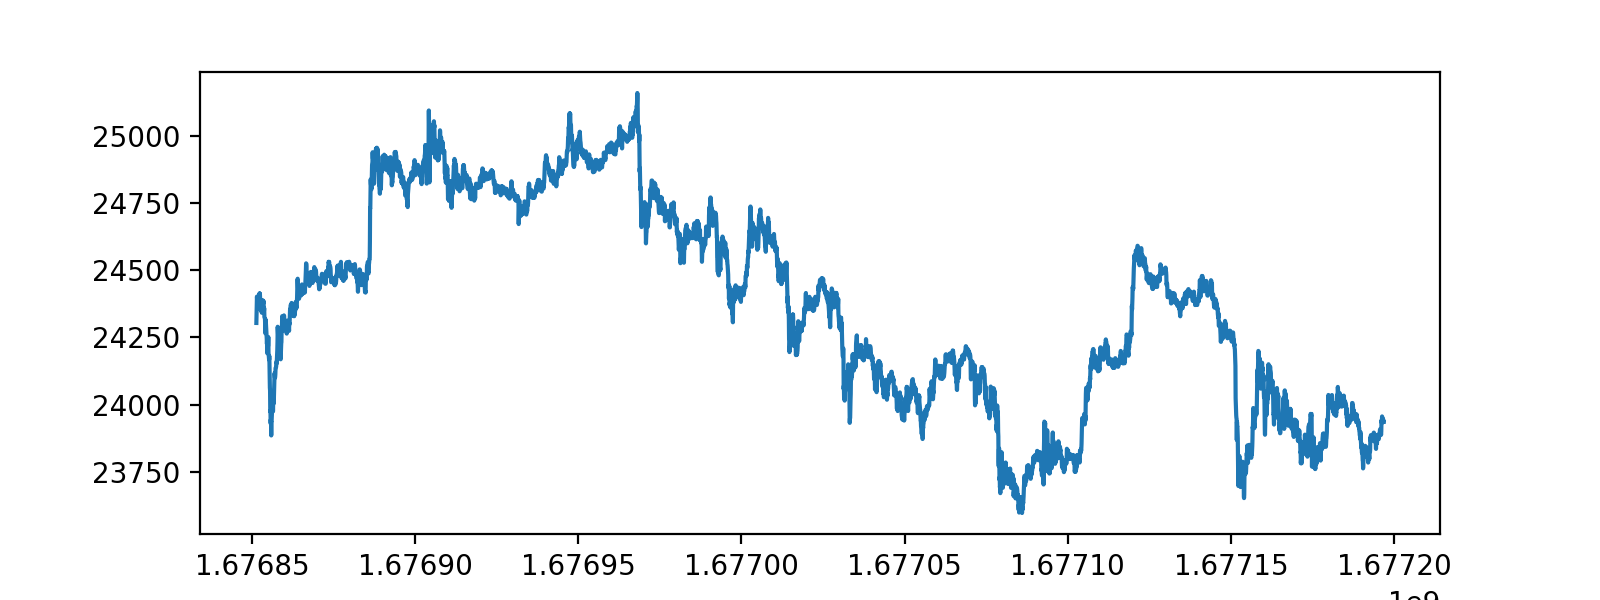

In [127]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(dataset["lowest_ask"])

# Формирование целевой переменной тренда

Что я хочу получить - усредненное значение будущих курсов для текущей точки (без текущего значения).
Весами и количество точек можно будет играться для оптимизации

In [237]:
# Количество "будущих" элементов для усреднения
num = 3

# Базово рассматриваем возможность применять разные веса к значениям. 
# Но в текущем конфиге все коэффициенты равны и уравновешивают сумму.
# ХЗ надо ли так извращаться, но пока оставлю.
weights = np.linspace(1/num, 1/num, num)

# Для корректной работы функции rolling (чтобы окно шлоу в нужную сторону) нужно отсортировать датафрейм
df = dataset.sort_index(ascending=False)
df['y'] = df['highest_bid'].rolling(window=num, closed='left').apply(lambda x: np.sum(weights*x))

# Проверка того, что мы делаем

values = df["highest_bid"].values[:num]
mean = values.mean()
print(f"Значения {values}, среднее {mean}")


df['y_'] = df['y']/df['highest_bid']-1


display(df[["highest_bid", "y", "y_"]].head())

# удаляем NA (после rolling) и возвращаем сортировку
df.dropna(inplace=True)
df = df.sort_index(ascending=True)




Значения [23929.621 23936.781 23929.38 ], среднее 23931.927333333337


,highest_bid,y,y_
ts,,,
1677196799,23929.621,NaN,NaN
1677196739,23936.781,NaN,NaN
1677196679,23929.380,NaN,NaN
1677196619,23929.771,23931.927333,0.000090
1677196559,23933.201,23931.977333,-0.000051


<IPython.core.display.Javascript object>


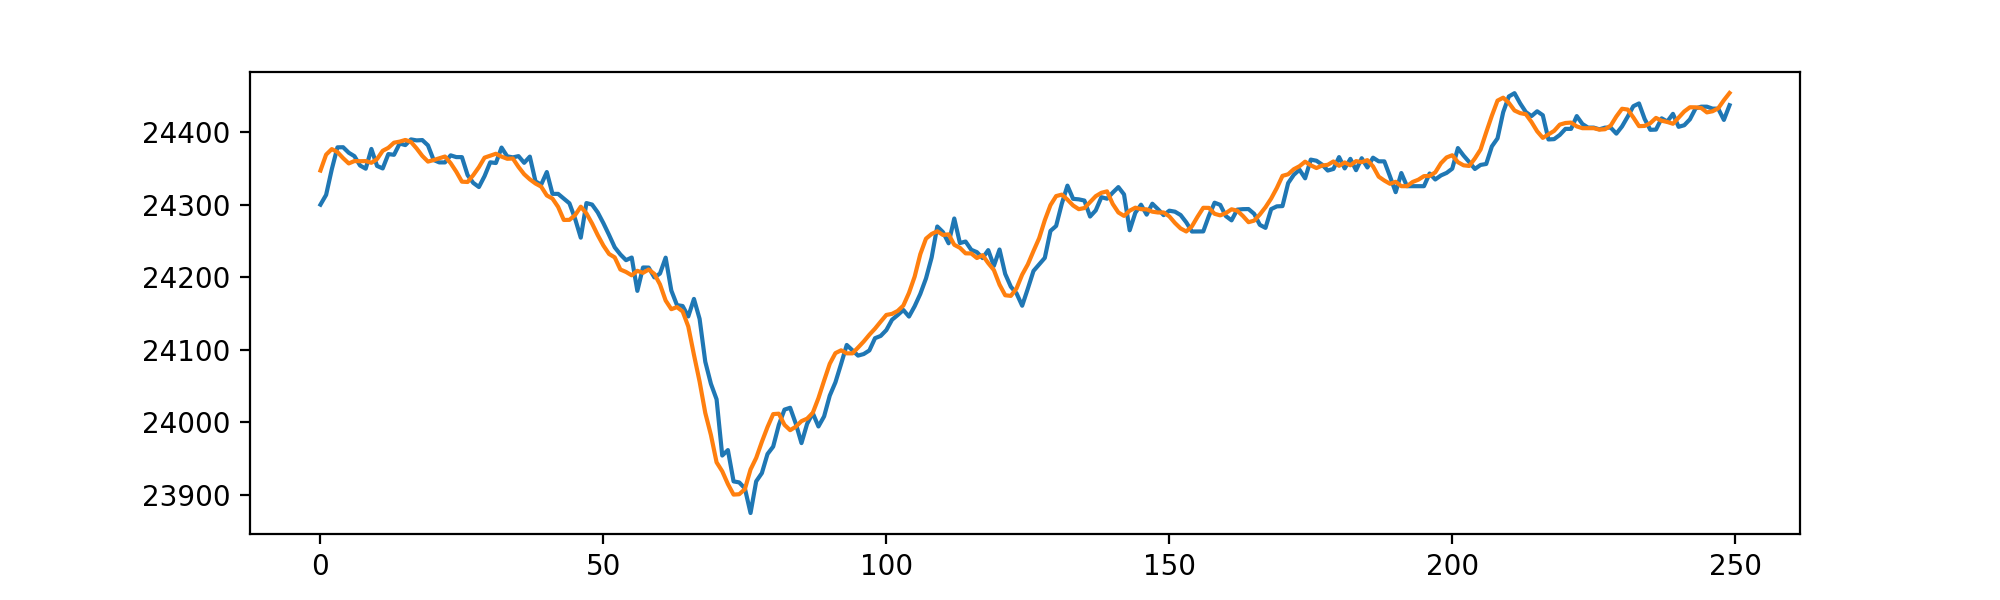

In [172]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df["highest_bid"].values[:250])
ax.plot(df["y"].values[:250])

# EDA

In [225]:
def add_bar_data(data, feature, start_idx, num, ax=None):
    ax2 = ax.twinx()
    x = np.arange(start_idx, start_idx+num)
    mask = data[feature].values[start_idx:start_idx+num]>=0
    pos = data[feature].values[start_idx:start_idx+num] * mask
    mask = data[feature].values[start_idx:start_idx+num]<0
    neg = data[feature].values[start_idx:start_idx+num] * mask

    
    ax2.bar(x , pos, alpha=0.3, color='green')
    ax2.bar(x , neg, alpha=0.3, color='red')
    

    
def add_bar_data2(x, series, ax=None):
    ax2 = ax.twinx()
    mask = series.values>=0
    pos = series.values * mask
    mask = series.values<0
    neg = series.values * mask

    ax2.bar(x , pos, alpha=0.3, color='green')
    ax2.bar(x , neg, alpha=0.3, color='red')


## Moving Average

In [226]:
# Количество "будущих" элементов для усреднения
ma_1_window = 5
ma_2_window = 15

# Для корректной работы функции rolling (чтобы окно шлоу в нужную сторону) нужно отсортировать датафрейм
#df = dataset.copy()
df['ma_1'] = df['highest_bid'].rolling(window=ma_1_window, closed='right').mean()
df['ma_2'] = df['highest_bid'].rolling(window=ma_2_window, closed='right').mean()
df.dropna(inplace=True)
df['ma_diff'] = df['ma_1'] - df['ma_2']

df['ma_diff_'] = df['ma_diff'].diff()
df.dropna(inplace=True)

<IPython.core.display.Javascript object>


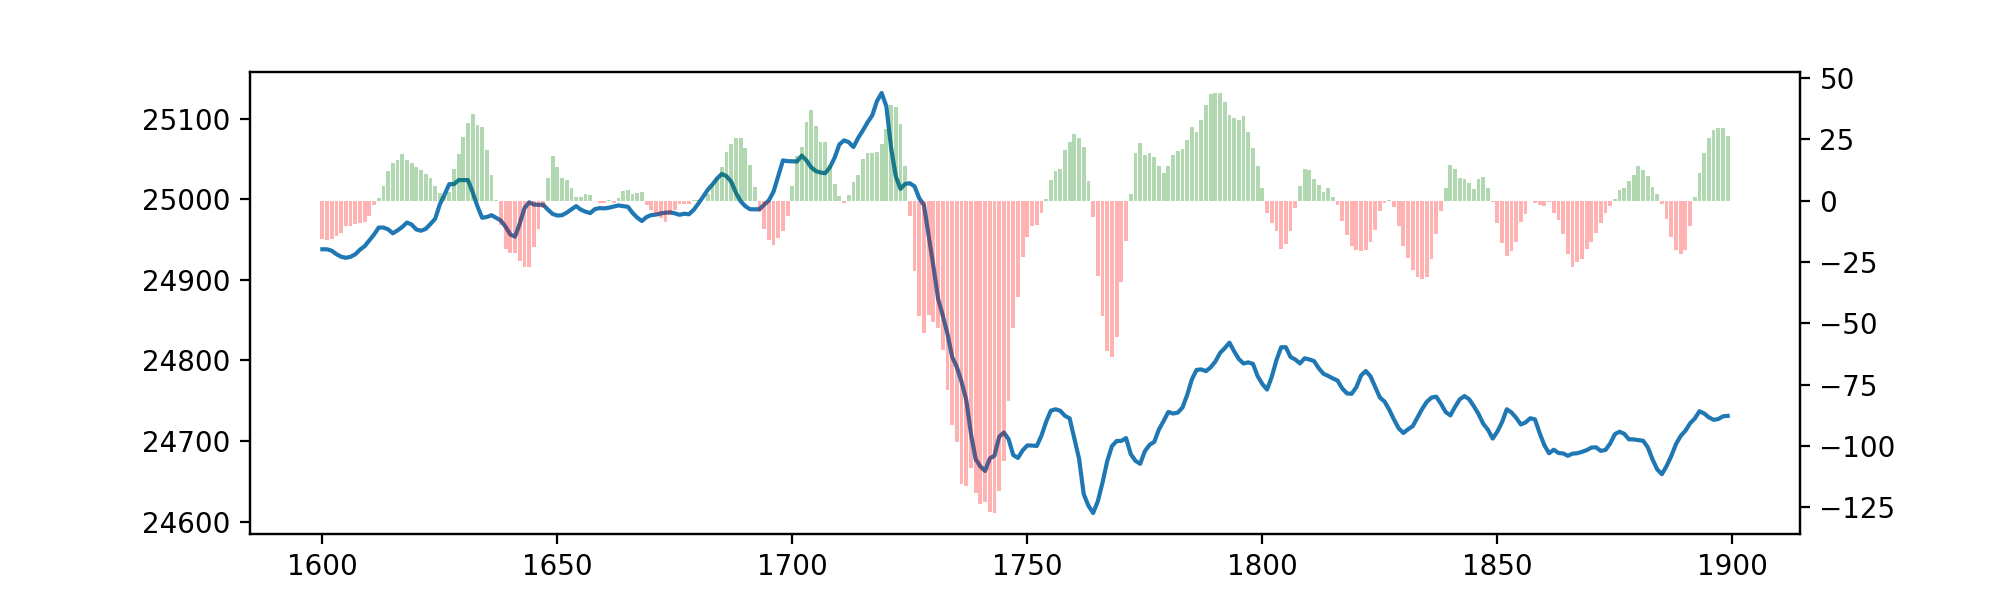

In [227]:
start_idx = 1600
num = 300
x = np.arange(start_idx, start_idx+num)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(x, df["y"].values[start_idx:start_idx+num])
add_bar_data(df, "ma_diff", start_idx, num, ax=ax)
#ax.plot(df["ma_1"].values[start_idx:start_idx+num])
#ax.plot(df["ma_2"].values[start_idx:start_idx+num])

<IPython.core.display.Javascript object>


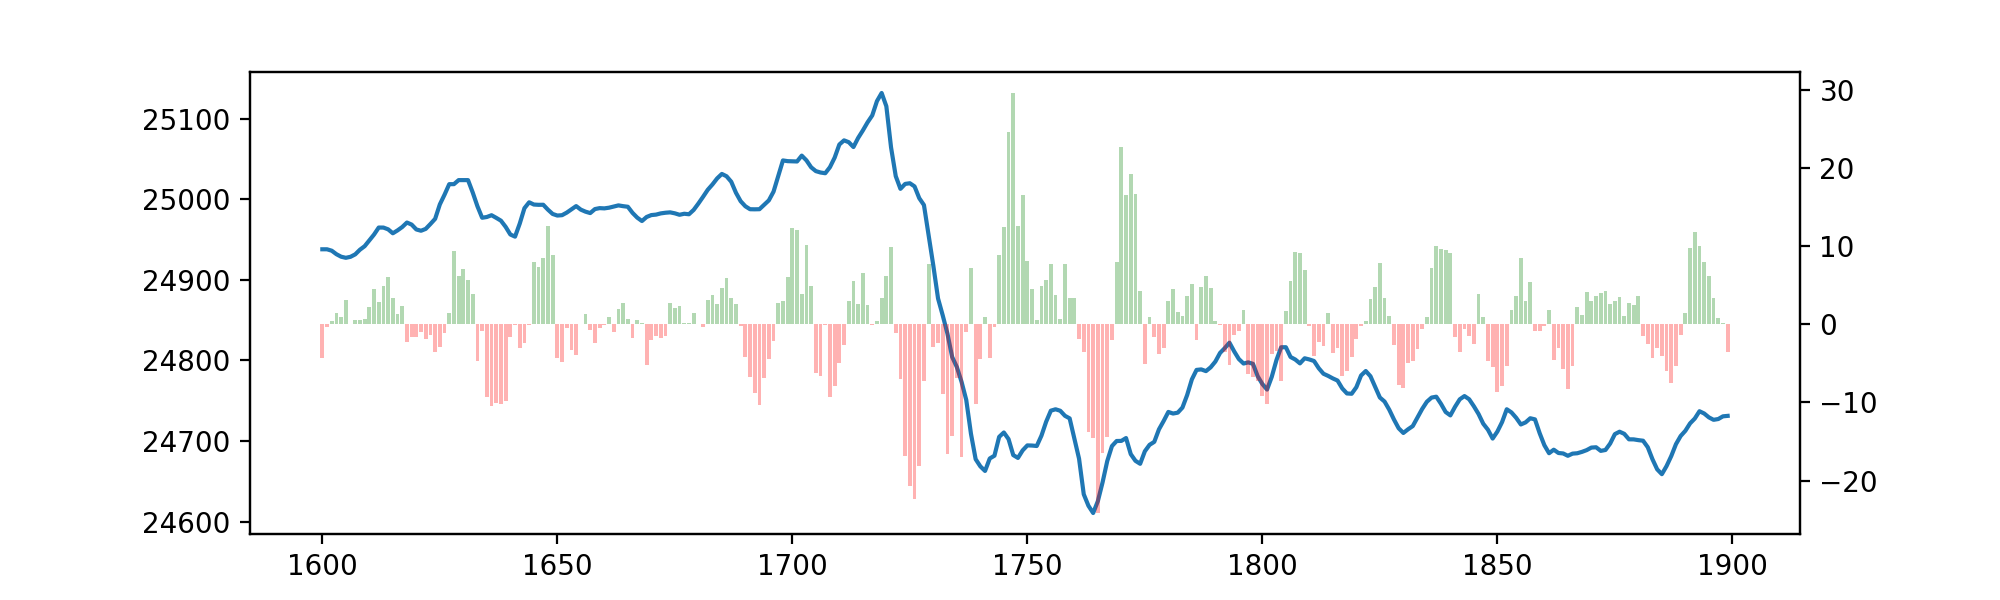

In [228]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(x, df["y"].values[start_idx:start_idx+num])

add_bar_data2(x, df.loc[:,"ma_diff_"].iloc[start_idx:start_idx+num], ax=ax)

In [221]:
add_bar_data2(df.loc[:,"ma_diff_"].iloc[start_idx:start_idx+num], ax=ax)


## Volume predictors

Список предикторов
 - buy_vol, sell_vol, total_vol	- объемы торговых операций за период
 - buy_num, sell_num, total_num
 - asks_xxx', 'bids_xxx' - значения стаканов по уровням
 

### Trade volumes vs predictor

In [202]:
df["trade_vol_diff"] = df["buy_vol"]-df["sell_vol"]
df["trade_vol_num"] = df["buy_num"]-df["sell_num"]
df["trade_vol_diff_rel"] = (df["sell_vol"]-df["buy_vol"])/(df["buy_vol"]+df["sell_vol"])

<IPython.core.display.Javascript object>


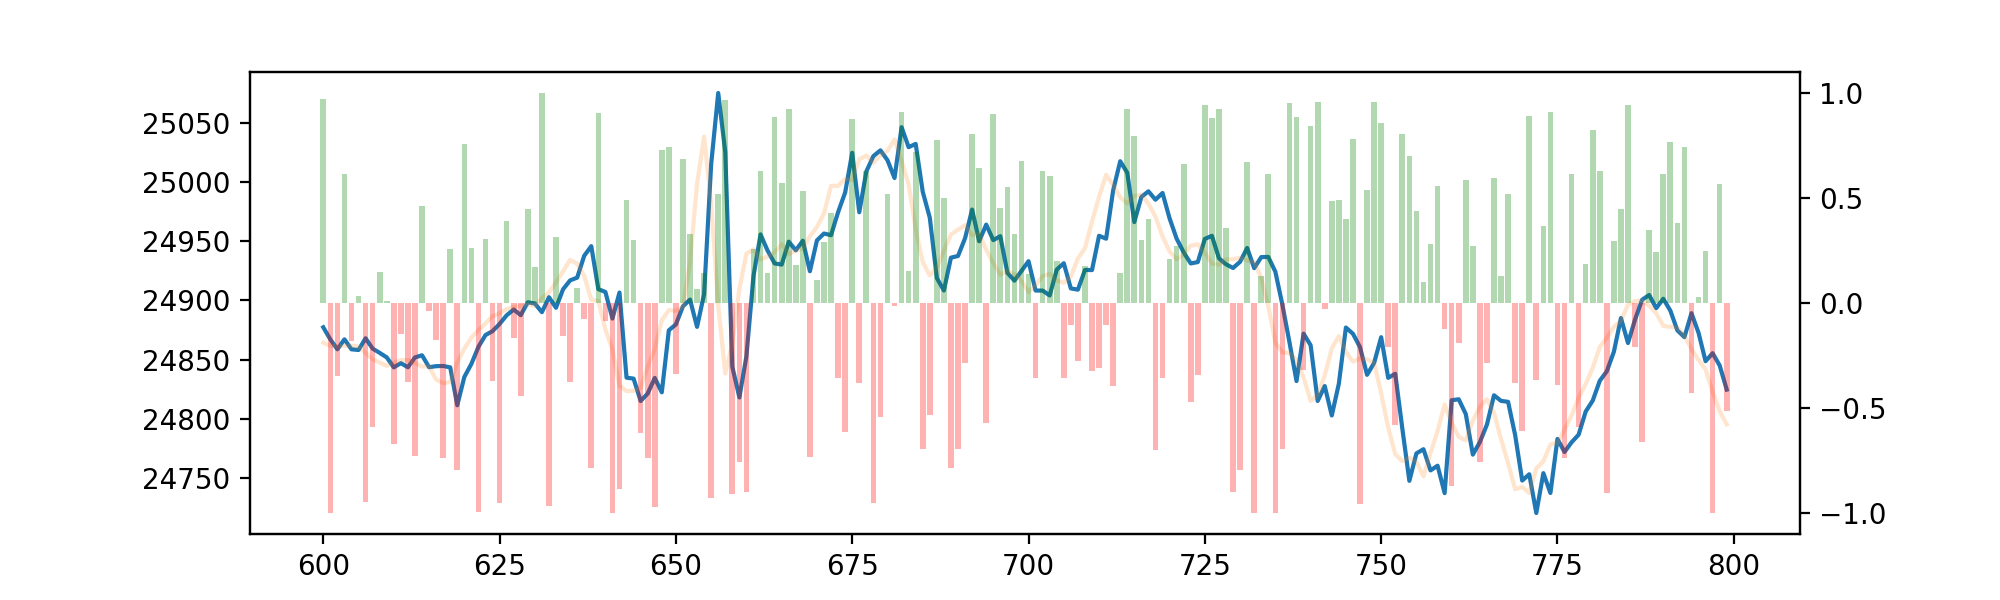

In [229]:
feature = "trade_vol_diff_rel"

start = 600
num = 200
#--------------------
x = np.arange(start,start+num)
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(x, df["highest_bid"].values[start:start+num])
ax.plot(x, df["y"].values[start:start+num], alpha=0.2)


add_bar_data2(x, df.loc[:,feature].iloc[start:start+num], ax=ax)




<IPython.core.display.Javascript object>


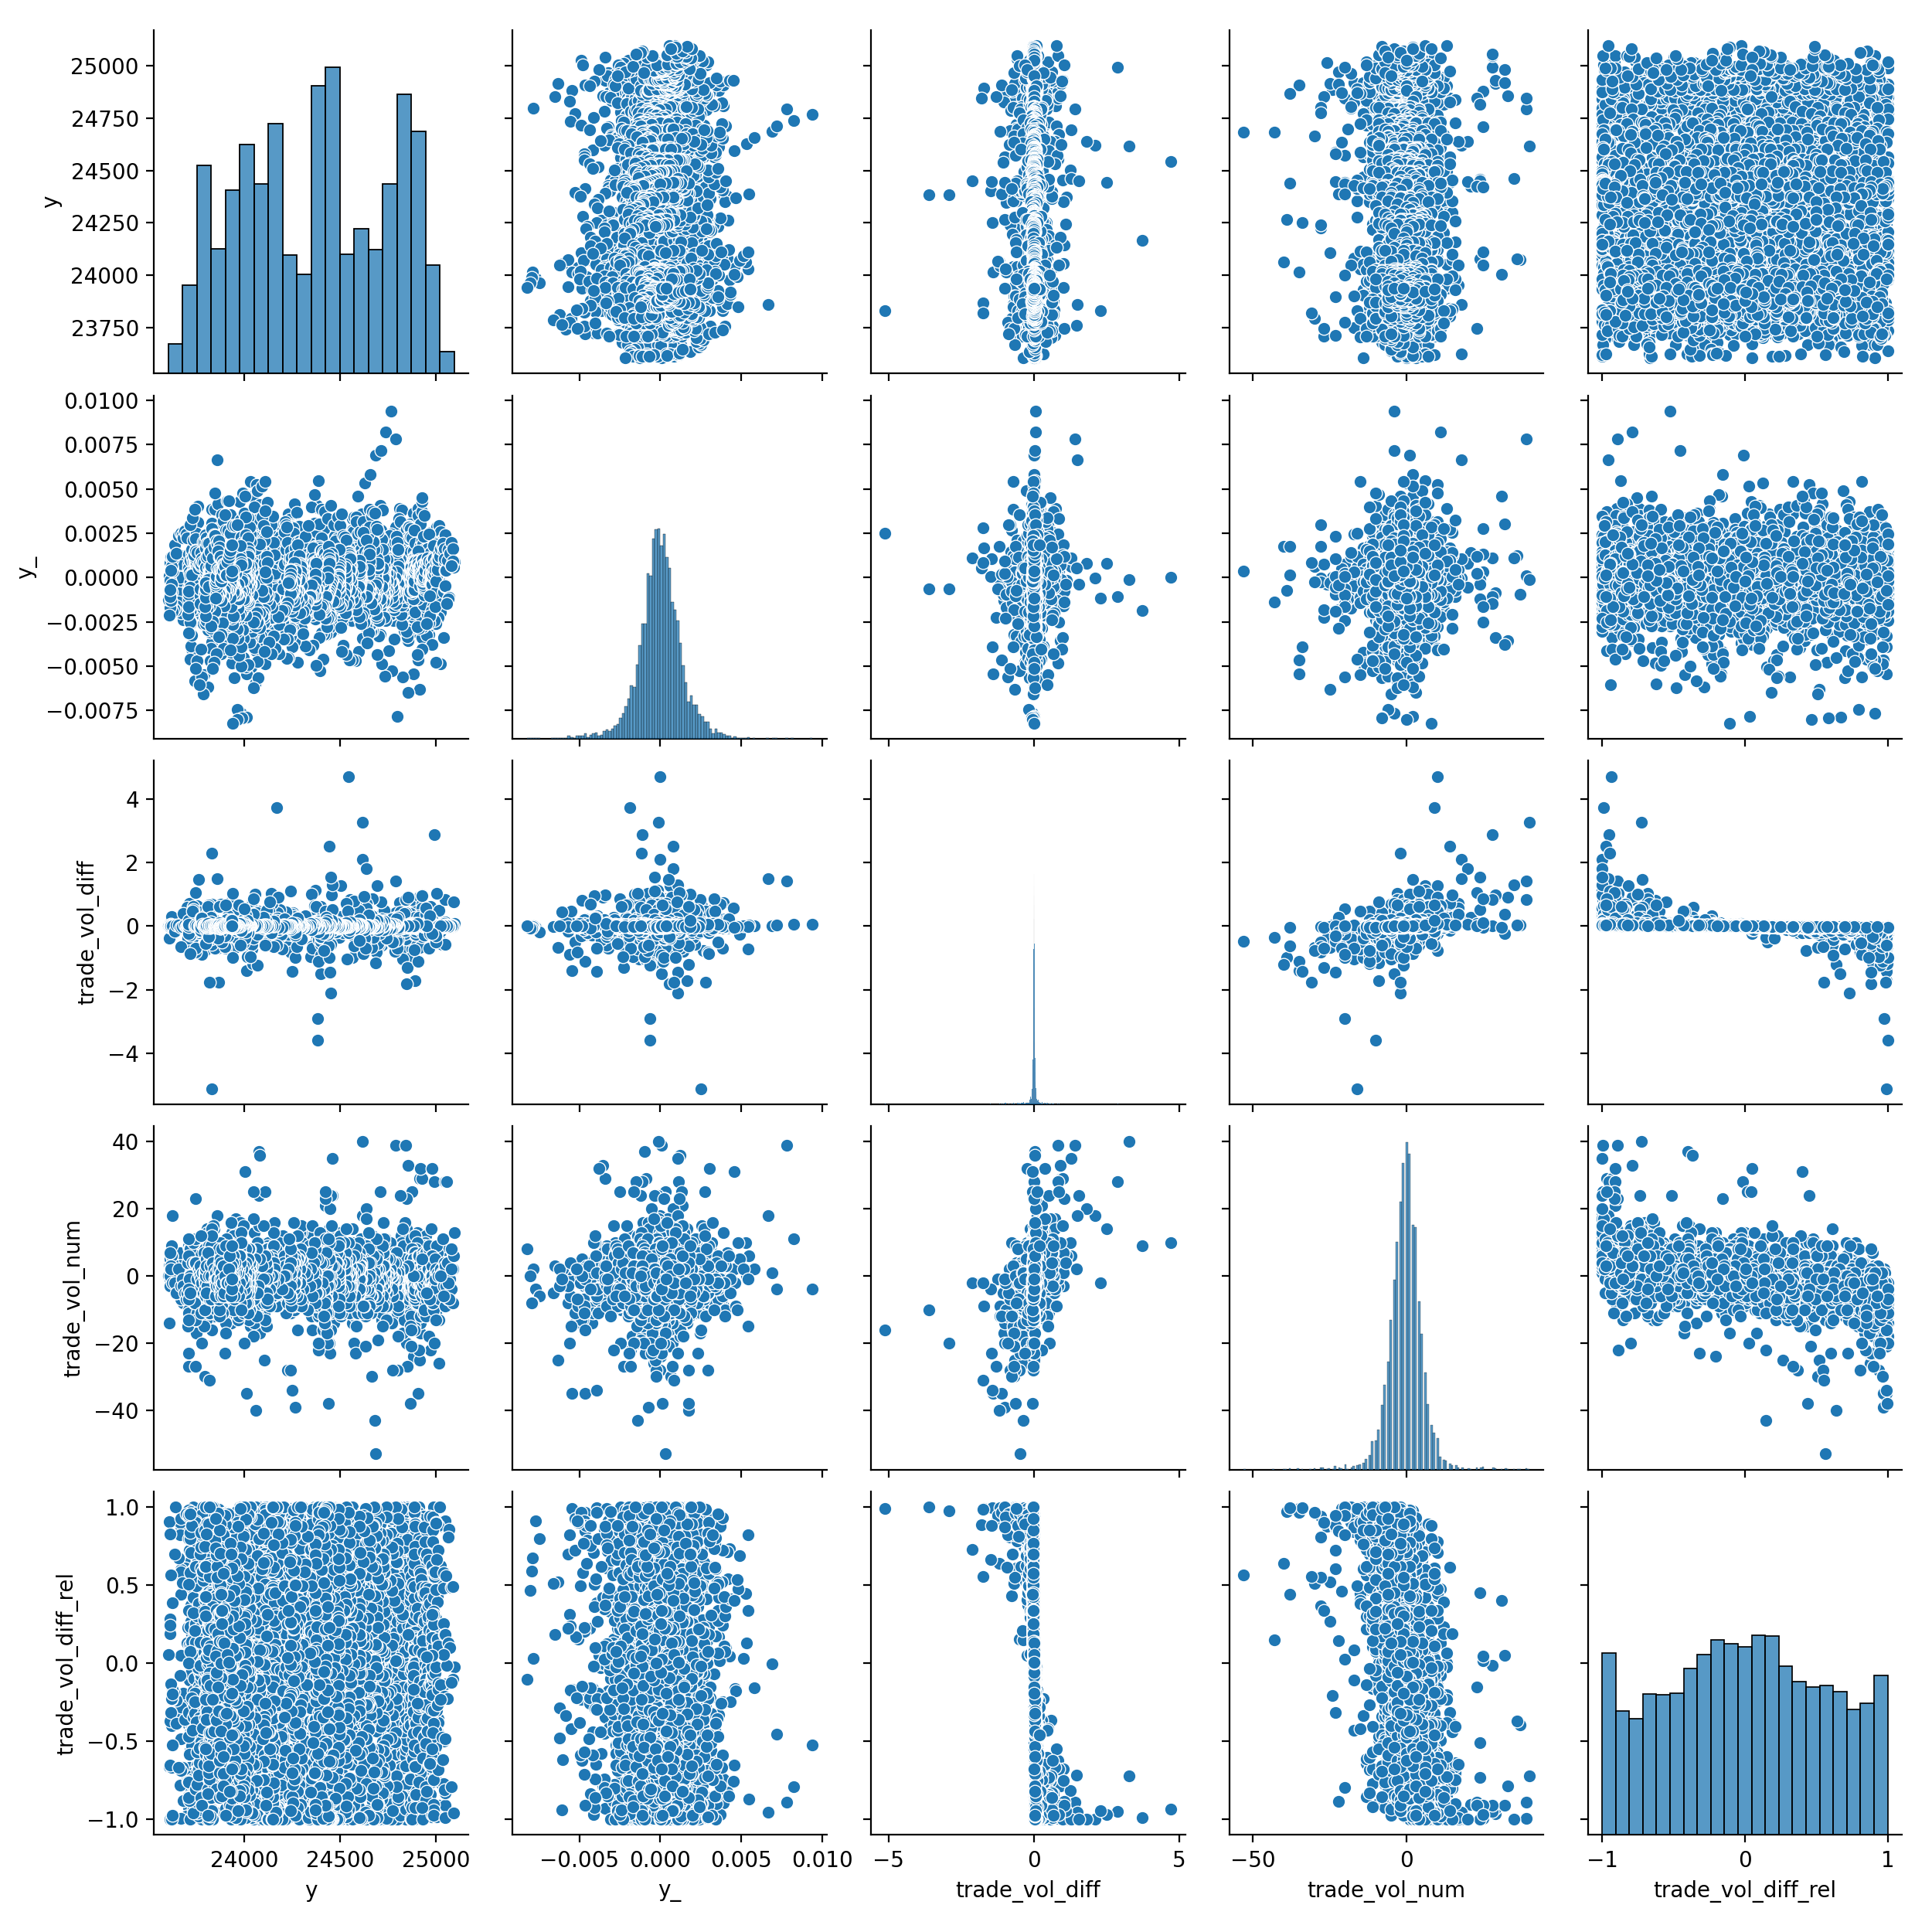

In [153]:
columns = [
    "y",
    "y_",
    "trade_vol_diff",
    "trade_vol_num",
    "trade_vol_diff_rel"

]

sns.pairplot(data=df.loc[:, columns])

## Orderbook

In [236]:
df.head()

,dt,lowest_ask,highest_bid,asks,bids,buy_vol,sell_vol,total_vol,buy_num,sell_num,...,ma_2,ma_diff,ma_diff_,trade_vol_diff,trade_vol_num,trade_vol_diff_rel,ob_vol_diff_1,ob_vol_diff_2,ob_vol_diff_3,ob_vol_diff_4
ts,,,,,,,,,,,,,,,,,,,,,
1676864819,2023-02-20 06:46:59,24412.451,24406.71,"{'24412.45': 0.012829, '24412.46': 0.00207, '2...","{'24406.71': 1.052254, '24406.70': 0.18, '2440...",0.008218,0.039888,0.048106,2,5,...,24415.585200,-5.043400,3.214067,-0.031670,-3,0.658338,0.471659,0.246488,0.108625,0.026436
1676864879,2023-02-20 06:47:59,24411.950,24404.35,"{'24411.95': 0.14, '24411.96': 0.011846, '2441...","{'24404.35': 1.053339, '24404.34': 0.002075, '...",0.005868,0.023735,0.029603,4,4,...,24412.259867,-1.842067,3.201333,-0.017867,0,0.603554,0.696645,0.481842,0.340129,0.218538
1676864939,2023-02-20 06:48:59,24412.451,24406.71,"{'24412.45': 0.011846, '24412.46': 0.00207, '2...","{'24406.71': 1.053176, '24406.70': 0.18, '2440...",0.004833,0.017632,0.022465,1,4,...,24410.031933,-2.794133,-0.952067,-0.012799,-3,0.569731,0.375499,0.246720,0.108718,0.026495
1676864999,2023-02-20 06:49:59,24412.460,24406.71,"{'24412.46': 0.00207, '24416.96': 0.001226, '2...","{'24406.71': 1.052854, '24406.70': 0.18, '2440...",0.009073,0.009520,0.018593,2,3,...,24408.598000,-2.360000,0.434133,-0.000447,-1,0.024041,0.695075,0.412976,0.369562,0.237200
1676865059,2023-02-20 06:50:59,24406.360,24398.42,"{'24406.36': 0.14, '24406.38': 0.14, '24406.54...","{'24398.42': 1.057285, '24398.41': 0.002001, '...",0.009739,0.054501,0.064240,2,6,...,24406.984600,-2.404600,-0.044600,-0.044762,-4,0.696793,0.165550,0.185074,0.204058,0.106517


In [259]:
i = 0
for level in precompute_config["orderbook_levels"]:
    i += 1
    df[f"ob_vol_diff_rel_{i}"] = (-df[f"asks_{level}"]+df[f"bids_{level}"])/(df[f"asks_{level}"]+df[f"bids_{level}"])
    
    df[f"ob_vol_diff_{i}"] = df[f"bids_{level}"]-df[f"asks_{level}"]

<IPython.core.display.Javascript object>


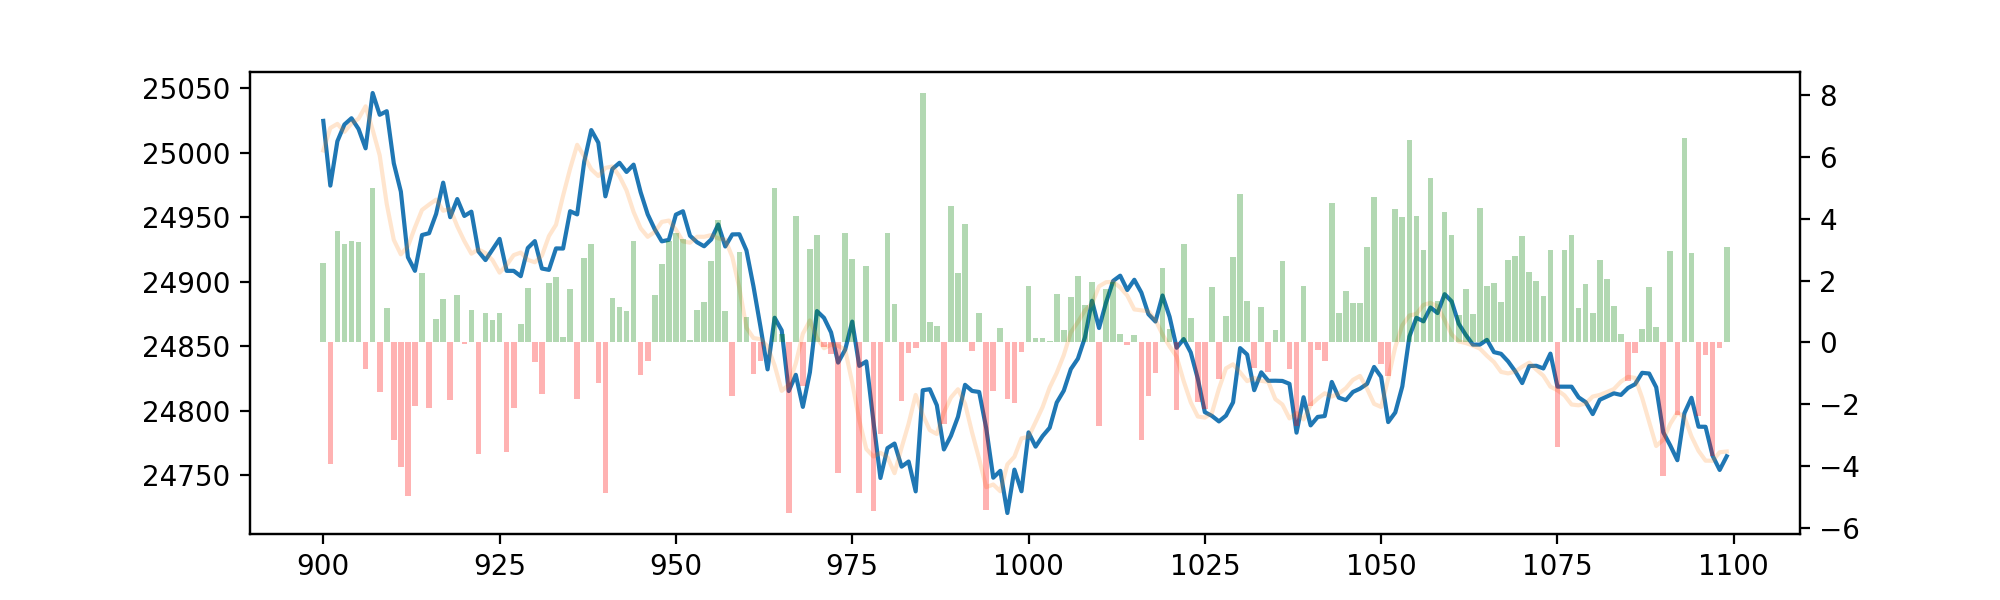

In [267]:
feature = "ob_vol_diff_3"

start = 900
num = 200
#--------------------
x = np.arange(start,start+num)
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(x, df["highest_bid"].values[start:start+num])
ax.plot(x, df["y"].values[start:start+num], alpha=0.2)

add_bar_data2(x, df.loc[:,feature].iloc[start:start+num], ax=ax)

In [121]:
np.correlate(df['y_'].values, df['trade_vol_diff'].values)

array([0.05086519])

In [122]:
df["ob_vol_diff_0.001"] = (df["asks_0.001"]-df["bids_0.001"])/(df["asks_0.001"]+df["bids_0.001"])


In [124]:
np.correlate(df['y_'].values, df['ob_vol_diff_0.001'].values)

array([nan])

In [125]:
df["ob_vol_diff_0.001"]

ts
1662185340         NaN
1662185640    0.708025
1662185940    0.244983
1662186240    1.000000
1662186540   -1.000000
                ...   
1662679440   -1.000000
1662679740    0.117952
1662680040    1.000000
1662680340    0.268169
1662680640   -0.374069
Name: ob_vol_diff_0.001, Length: 1652, dtype: float64

In [1]:
import time

In [2]:
time.time()

1694200179.771601

In [12]:
class TestClass:
    def __init__(self, a):
        self.a = a
        
def run():
    x = 1 + 2
    s = TestClass(x)
    return s
    
start = time.time()
for i in range(5000000):
    a = run()
    
end = time.time()
print(f"Runtime {end-start:.2f}")


Runtime 1.95


In [15]:
id(a)

140184259005552

In [16]:
id(a.__dict__)

140184273321024